# Modelling on Unbalanced Data: Caravan Insurance

Imports

In [0]:
#%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,f1_score
from lightgbm import LGBMClassifier
import itertools
import scipy.stats as ss


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!pip install lightgbm

In [0]:
RS=410 #Random State

In [0]:
data=pd.read_csv('caravan-insurance-challenge.csv')
data.head()

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [0]:
data.shape

(9822, 87)

In [0]:
data.columns

Index(['ORIGIN', 'MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD',
       'MGODRK', 'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV',
       'MFALLEEN', 'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG',
       'MBERHOOG', 'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO',
       'MSKA', 'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1',
       'MAUT2', 'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045',
       'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART',
       'PWABEDR', 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT',
       'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG',
       'PGEZONG', 'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS',
       'PINBOED', 'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT',
       'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT',
       'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND',
       'AZEILPL', 'APLEZIER',

In [0]:
data.ORIGIN.value_counts()

train    5822
test     4000
Name: ORIGIN, dtype: int64

Data Analysis

No NA values,all variables are type of int64.The data is peculiar in that every numeric stands for an attribute of person.Even variables that could be continuous,such as income have been binned.

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9822 entries, 0 to 9821
Data columns (total 87 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ORIGIN    9822 non-null   object
 1   MOSTYPE   9822 non-null   int64 
 2   MAANTHUI  9822 non-null   int64 
 3   MGEMOMV   9822 non-null   int64 
 4   MGEMLEEF  9822 non-null   int64 
 5   MOSHOOFD  9822 non-null   int64 
 6   MGODRK    9822 non-null   int64 
 7   MGODPR    9822 non-null   int64 
 8   MGODOV    9822 non-null   int64 
 9   MGODGE    9822 non-null   int64 
 10  MRELGE    9822 non-null   int64 
 11  MRELSA    9822 non-null   int64 
 12  MRELOV    9822 non-null   int64 
 13  MFALLEEN  9822 non-null   int64 
 14  MFGEKIND  9822 non-null   int64 
 15  MFWEKIND  9822 non-null   int64 
 16  MOPLHOOG  9822 non-null   int64 
 17  MOPLMIDD  9822 non-null   int64 
 18  MOPLLAAG  9822 non-null   int64 
 19  MBERHOOG  9822 non-null   int64 
 20  MBERZELF  9822 non-null   int64 
 21  MBERBOER  9822

Every feature is already encoded as an integer representation,saving us the conversion work.

In [0]:
data.CARAVAN.value_counts()

0    9236
1     586
Name: CARAVAN, dtype: int64

Now,we are dealing with a very imbalanced dataset.

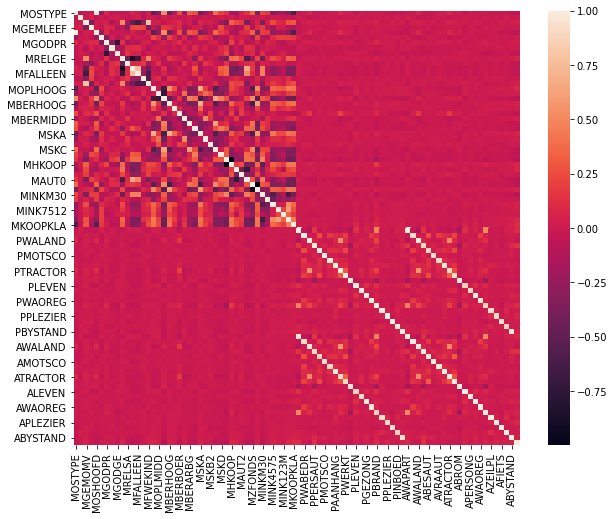

In [0]:
plt.subplots(figsize=(10,8))
sns.heatmap(data.drop(columns=['ORIGIN']).corr());

A correlation plot shows some interesting patterns in the data.There is a clear divide between the two groupings listed in the description file . 

Text(0.5, 1.0, 'Bottom-right Corrplot')

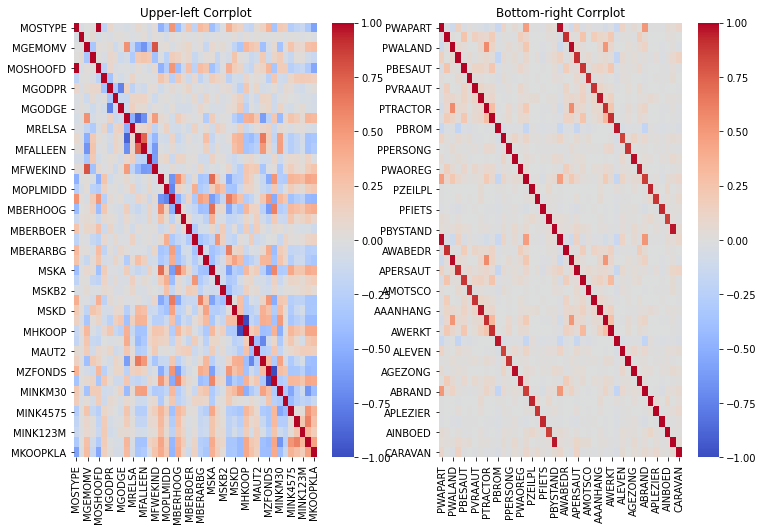

In [0]:
fig,axes=plt.subplots(1,2,figsize=(12,8))
sns.heatmap(data.drop(columns=["ORIGIN"]).iloc[:,:43].corr(),vmin=-1,vmax=1,cmap='coolwarm',ax=axes[0])
sns.heatmap(data.drop(columns=['ORIGIN']).iloc[:,43:].corr(),vmin=-1,vmax=1,cmap='coolwarm',ax=axes[1])
axes[0].set_title("Upper-left Corrplot")
axes[1].set_title("Bottom-right Corrplot")

after zooming in bit,Bottom-right corrplot shows how variables starting with P each have a corresponding variable starting with A this means that having both in our data will likely provide little value.

In [0]:
#Drop percentage representations
data_np=data.drop(columns=data.loc[:,(data.columns.str.startswith('p'))]).copy()
data_np.to_feather('reduced_cmbd.df')

In [0]:
!pip install pyarrow

**MODELS**



4 Models will be used in total:BaggingClassifier,RandomForestClassifier,AdaBoostClassifier from sklearn and Microsoft's lightgbm

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, cf_report=False,
                          title='Confusion matrix', ax=None, cmap=plt.cm.Blues, cbar=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    if cf_report:
        print(classification_report(y_true,y_pred))
    
    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(1,1)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    
    if cbar:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04) # "Magic" numbers (https://stackoverflow.com/a/26720422/10939610)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [0]:
def plot_roc(y_true, y_pred, ax=None):
    """Plot ROC curve""" 
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_pred)
    roc_score = roc_auc_score(y_true,y_pred)
    
    fig, ax = (plt.gcf(), ax) if ax is not None else plt.subplots(1,1)

    ax.set_title("Receiver Operating Characteristic")
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    ax.annotate('ROC: {:.5f}'.format(roc_score), [0.75,0.05])
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    fig.tight_layout()
    return roc_score

In [0]:
def feat_imps(model, X_train, plot=False, n=None):
    """ Dataframe containing each feature with its corresponding importance in the given model
    
    Args
    ----
        model : model, classifier that supports .feature_importances_ (RandomForest, AdaBoost, ect..)
        X_train : array like, training data object
        plot : boolean, if True, plots the data in the form of a bargraph
        n : int, only applicable if plot=True, number of features to plot, (default=15)
        
    Returns
    -------
        pandas DataFrame : columns = feature name, importance
    """
    
    fi_df = pd.DataFrame({'feature':X_train.columns,
                          'importance':model.feature_importances_}
                        ).sort_values(by='importance', ascending=False)
    if plot:
        fi_df[:(n if n is not None else 15)].plot.bar(x='feature',y='importance')
    else:
        return fi_df

In [0]:
def plot_cmroc(y_true, y_pred, classes=[0,1], normalize=True, cf_report=False):
    """Convenience function to plot confusion matrix and ROC curve """
    fig,axes = plt.subplots(1,2, figsize=(9,4))
    plot_confusion_matrix(y_true, y_pred, classes=classes, normalize=normalize, cf_report=cf_report, ax=axes[0])
    roc_score = plot_roc(y_true, y_pred, ax=axes[1])
    fig.tight_layout()
    plt.show()
    return roc_score

In [0]:
train_df=data.query("ORIGIN=='train'").iloc[:,1:].copy()
test_df=data.query("ORIGIN=='test'").iloc[:,1:].copy()

The test data will be treated as holdout test set,so we will split train_df into a training validation set.

In [0]:
X,y=train_df.drop(columns='CARAVAN'),train_df.CARAVAN
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.20,random_state=RS)

To address the issue with imbalanced data,we will compare three approaches for each model used:
1.Random Over Sampling
2.Random Under Sampling
3.SMOTE(Synthetic Minority Over-Sampling Technique)


In [0]:
!pip install imblearn

In [0]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
ros=RandomOverSampler(random_state=RS)
rus=RandomUnderSampler(random_state=RS)
smt=SMOTE(random_state=RS,n_jobs=-1)
X_under,y_under=rus.fit_sample(X_train,y_train)
X_over,y_over=ros.fit_sample(X_train,y_train)
X_smote,y_smote=smt.fit_sample(X_train,y_train)
pd.DataFrame([*map(lambda x:ss.describe(x)._asdict(),[y_train,y_under,y_over,y_smote])],index=['Unbalanced','Undersample','Oversample','SMOTE'])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

,nobs,minmax,mean,variance,skewness,kurtosis
Unbalanced,4657,"(0, 1)",0.060339,0.056711,3.692854,11.637168
Undersample,562,"(0, 1)",0.500000,0.250446,0.000000,-2.000000
Oversample,8752,"(0, 1)",0.500000,0.250029,0.000000,-2.000000
SMOTE,8752,"(0, 1)",0.500000,0.250029,0.000000,-2.000000


Without doing any sort of resampling,the mean was ~0.058 with heavy skew.Each method of resampling has shifted the mean to 0.5 and eliminated the skewness,each using a different method to achieve this.


In [0]:
#Define baseline models
bc=BaggingClassifier(n_estimators=53,random_state=RS,n_jobs=-1)
ada=AdaBoostClassifier(n_estimators=53,random_state=RS)
rfc=RandomForestClassifier(n_estimators=53,random_state=RS,n_jobs=-1)
lgbm=LGBMClassifier(n_estimators=53,random_state=RS,n_jobs=-1)

Unbalanced Data

Bagging

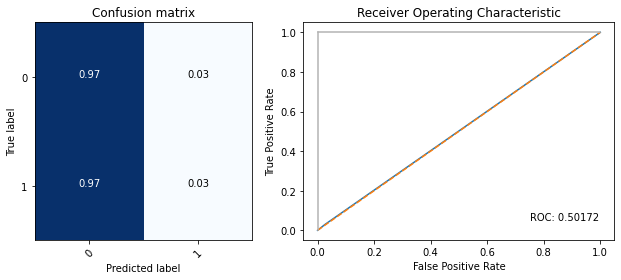

In [0]:
bc_unbal=plot_cmroc(y_val,bc.fit(X_train,y_train).predict(X_val))

Boosting(AdaBoost)


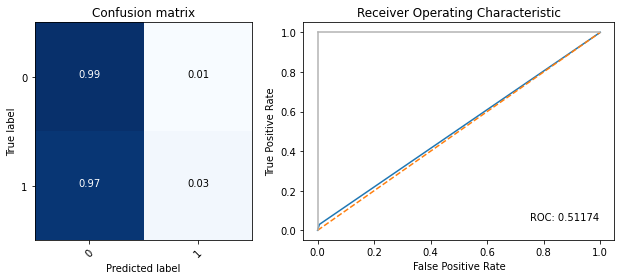

In [0]:
ada_unbal=plot_cmroc(y_val,ada.fit(X_train,y_train).predict(X_val))

Boosting(LGBM)

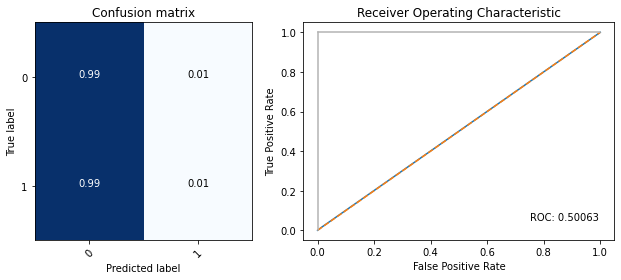

In [0]:
lgbm_unbal=plot_cmroc(y_val,lgbm.fit(X_train,y_train).predict(X_val))

Random Forest

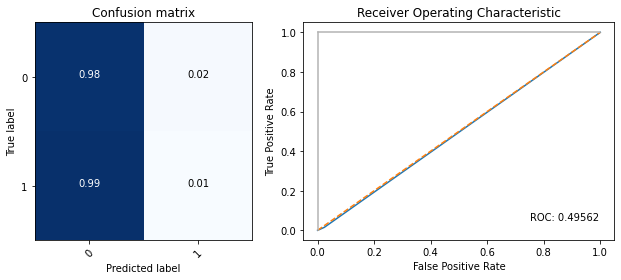

In [0]:
rfc_unbal=plot_cmroc(y_val,rfc.fit(X_train,y_train).predict(X_val))

Unbalanced Evaluation

In [0]:
models=[bc,ada,rfc,lgbm]
unbal_scores=[bc_unbal,ada_unbal,rfc_unbal,lgbm_unbal]
for model,score in zip(models,unbal_scores):
    print('{:25s}:{:.5f}'.format(model.__class__.__name__,score))

BaggingClassifier        :0.50172
AdaBoostClassifier       :0.51174
RandomForestClassifier   :0.49562
LGBMClassifier           :0.50063


Poor performance across all models when using the unbalanced dataset.AdaBoost was no better than random guessing and the best model,the BaggingClassifier.

# Undersampling

Bagging

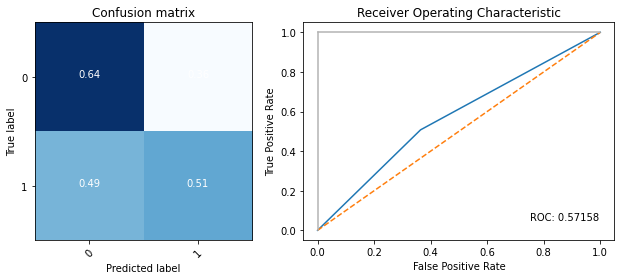

In [0]:
bc_under=plot_cmroc(y_val,bc.fit(X_under,y_under).predict(X_val))

Boosting(AdaBoost)

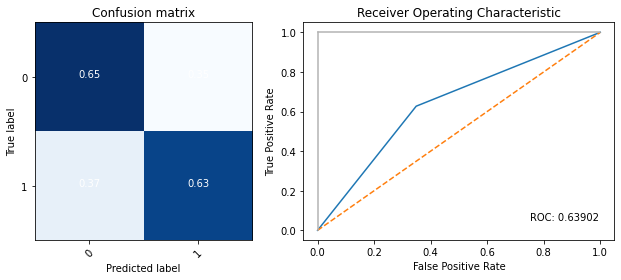

In [0]:
ada_under=plot_cmroc(y_val,ada.fit(X_under,y_under).predict(X_val))

Boosting(LGBM)

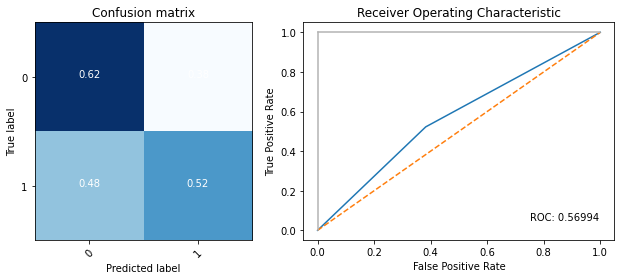

In [0]:
lgbm_under=plot_cmroc(y_val,lgbm.fit(X_under,y_under).predict(X_val))

Random Forest

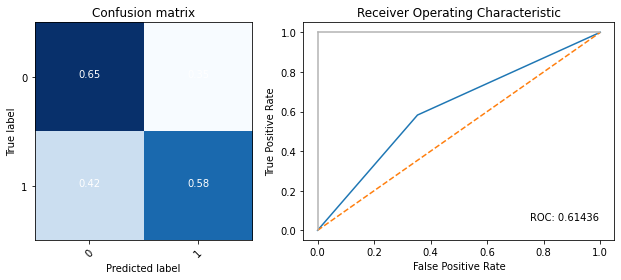

In [0]:
rfc_under=plot_cmroc(y_val,rfc.fit(X_under,y_under).predict(X_val))

Undersampling Evaluation

In [0]:
models=[bc,ada,rfc,lgbm]
under_scores=[bc_under,ada_under,rfc_under,lgbm_under]
for model,score in zip(models,under_scores):
    print('{:25s}:{:.5f}'.format(model.__class__.__name__,score))

BaggingClassifier        :0.57158
AdaBoostClassifier       :0.63902
RandomForestClassifier   :0.61436
LGBMClassifier           :0.56994


Nearly a 18% increase in ROC score was seen across the board using the undersampling method.

# Oversampling

Bagging

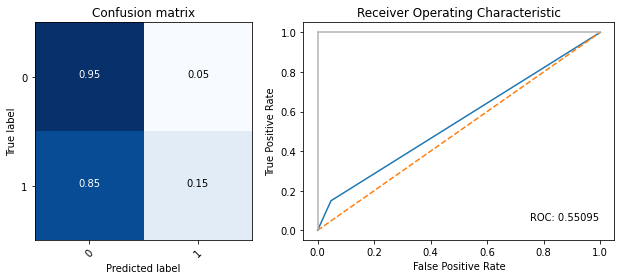

In [0]:
bc_over=plot_cmroc(y_val,bc.fit(X_over,y_over).predict(X_val))

Boosting(AdaBoost)

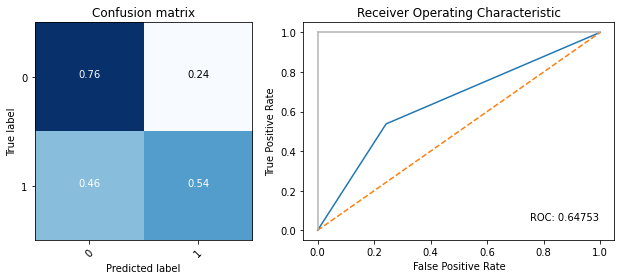

In [0]:
ada_over=plot_cmroc(y_val,ada.fit(X_over,y_over).predict(X_val))

Boosting(LGBM)

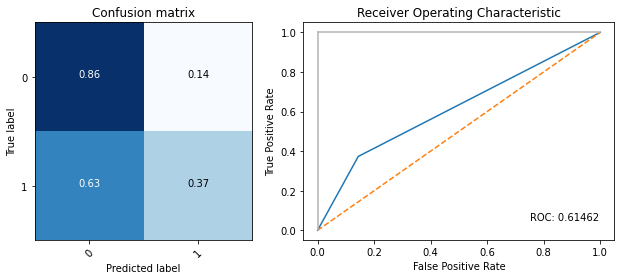

In [0]:
lgbm_over=plot_cmroc(y_val,lgbm.fit(X_over,y_over).predict(X_val))

Random Forest

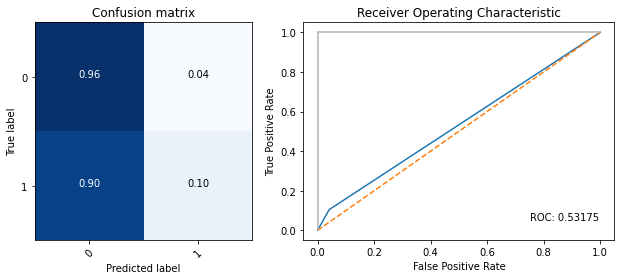

In [0]:
rfc_over=plot_cmroc(y_val,rfc.fit(X_over,y_over).predict(X_val))

# Oversampling Evaluation

In [0]:
models=[bc,ada,rfc,lgbm]
over_scores=[bc_over,ada_over,rfc_over,lgbm_over]
for model,score in zip(models,over_scores):
    print('{:25s}:{:.5f}'.format(model.__class__.__name__,score))

BaggingClassifier        :0.55095
AdaBoostClassifier       :0.64753
RandomForestClassifier   :0.53175
LGBMClassifier           :0.61462


In contrast with the unbalanced dataset,with the over sampled data,AdaBoost greatly out performed the other models with this data augmentation method.

# SMOTE

Bagging


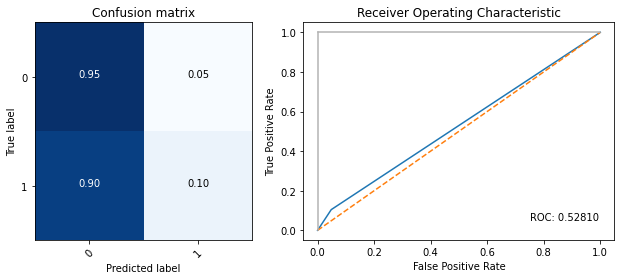

In [0]:
bc_smote=plot_cmroc(y_val,bc.fit(X_smote,y_smote).predict(X_val
                                                         ))

Boosting(AdaBoost)

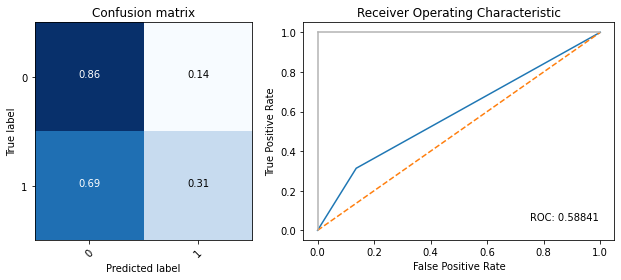

In [0]:
ada_smote=plot_cmroc(y_val,ada.fit(X_smote,y_smote).predict(X_val))

Boosting(LGBM)

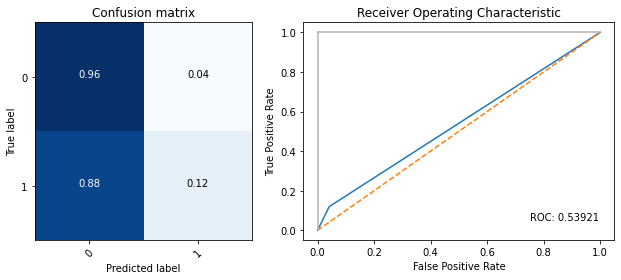

In [0]:
lgbm_smote=plot_cmroc(y_val,lgbm.fit(X_smote,y_smote).predict(X_val))

Random Forest

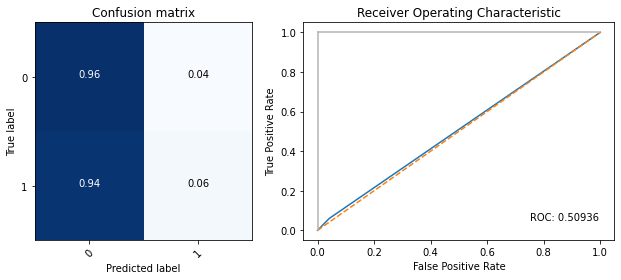

In [0]:
rfc_smote=plot_cmroc(y_val,rfc.fit(X_smote,y_smote).predict(X_val))

# SMOTE Evaluation

In [0]:
models=[bc,ada,rfc,lgbm]
smote_scores=[bc_smote,ada_smote,rfc_smote,lgbm_smote]
for model,score in zip(models,smote_scores):
    print('{:25s}:{:.5f}'.format(model.__class__.__name__,score))

BaggingClassifier        :0.52810
AdaBoostClassifier       :0.58841
RandomForestClassifier   :0.50936
LGBMClassifier           :0.53921


# Tweaking the best

For all of the classifiers,Random under sampling was the most successful method of rebalancing the dataset.With the exception of AdaBoost,the other methods barely outperformed random guessing.

Let's evaluate the best from each group against the holdout test data 

In [0]:
X_test,y_test=test_df.iloc[:,:-1],test_df.iloc[:,-1]

In [0]:
bc=BaggingClassifier(n_estimators=53,n_jobs=-1)
ada=AdaBoostClassifier(n_estimators=53,random_state=RS)
rfc=RandomForestClassifier(n_estimators=53,n_jobs=-1,random_state=RS)
lgbm=LGBMClassifier(n_estimators=53,random_state=RS)


In [0]:
models=[bc,ada,rfc,lgbm]
for model in models:
    model.fit(X_under,y_under)
    tpreds=model.predict(X_test)
    print('{:25s}:{:.5f}'.format(model.__class__.__name__,roc_auc_score(y_test,tpreds)))

BaggingClassifier        :0.65245
AdaBoostClassifier       :0.63926
RandomForestClassifier   :0.66351
LGBMClassifier           :0.65498


So,if this contest happened to evaluated on Area Under ROC,the best model we could have submitted would have been the Random Forest Classifier with a score of 0.66

A bit better of a score likely be achieved through ensembling these models as well,but there are many other tweaks.

# Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV
param_grid={
    'learning_rate':[0.01,0.05,0.1,1],
    'n_estimators':[20,40,60,80,100],
    'num_values':[3,7,17,31],
    'max_bin':[4,8,16,32,64],
    'min_child_samples':[3,5,10,20,30],
}

In [0]:
lgbm_gs=GridSearchCV(LGBMClassifier(),param_grid,n_jobs=-1,scoring='roc_auc',verbose=2,iid=False,cv=5)
lgbm_gs.fit(X_under,y_under)
print('Best parameters:',lgbm_gs.best_params_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 582 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 2526 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5766 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 7874 tasks      | elapsed:  5.5min


Best parameters: {'learning_rate': 0.1, 'max_bin': 32, 'min_child_samples': 5, 'n_estimators': 40, 'num_values': 3}


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  6.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


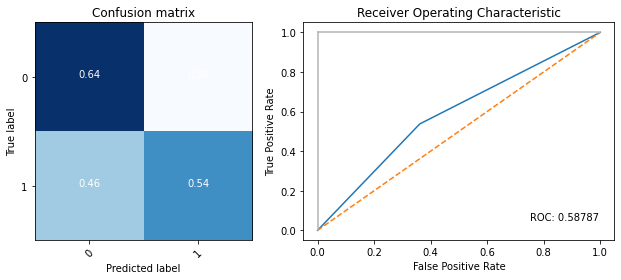

0.5878734741592584

In [0]:
plot_cmroc(y_val,lgbm_gs.predict(X_val))

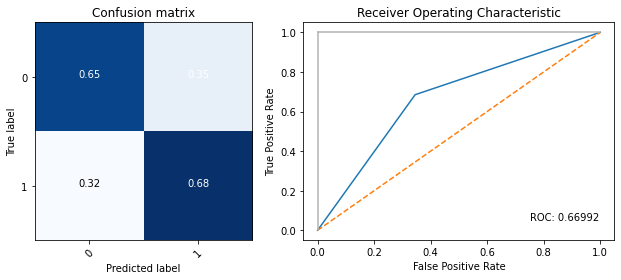

0.669922354906875

In [0]:
plot_cmroc(y_test,lgbm_gs.predict(X_test))

# Random Forest

In [0]:
param_grid_rf={
    'n_estimators':[40,60,100,128,256],
    'min_samples_leaf':[3,7,17,31],
    'max_leaf_nodes':[4,8,16,32,64],
    'min_samples_split':[3,5,10,20,30],
}

In [0]:
rfc_gs=GridSearchCV(RandomForestClassifier(),param_grid_rf,n_jobs=-1,scoring='roc_auc',verbose=2,iid=False,cv=5)
rfc_gs.fit(X_under,y_under)
print('Best parameters:',rfc_gs.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 718 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1284 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2014 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  6.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best parameters: {'max_leaf_nodes': 32, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 256}


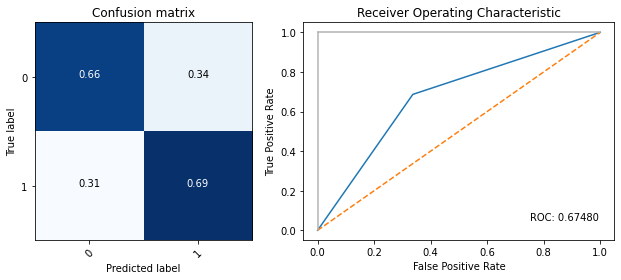

0.6747954217981132

In [0]:
plot_cmroc(y_val,rfc_gs.predict(X_val))

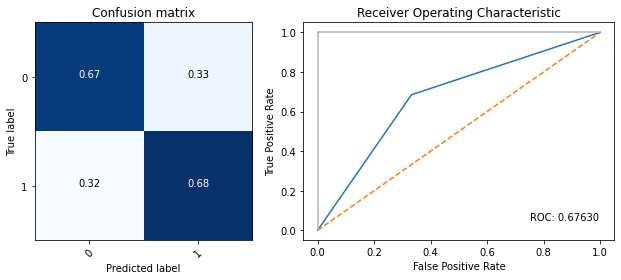

0.6763019402338287

In [0]:
plot_cmroc(y_test,rfc_gs.predict(X_test))

In [0]:
lgbm_gs_ub=GridSearchCV(LGBMClassifier(),param_grid,n_jobs=-1,scoring='roc_auc',verbose=1,iid=False,cv=5)
lgbm_gs_ub.fit(X_train,y_train)
print('Best parameters:',lgbm_gs_ub.best_params_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 3588 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 4888 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 6388 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 8088 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 9988 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 22.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best parameters: {'learning_rate': 0.05, 'max_bin': 16, 'min_child_samples': 3, 'n_estimators': 80, 'num_values': 3}


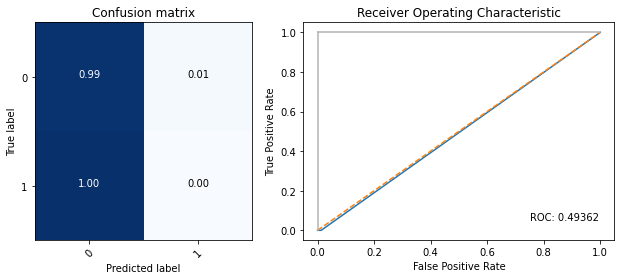

0.4936247723132969

In [0]:
plot_cmroc(y_val,lgbm_gs_ub.predict(X_val))

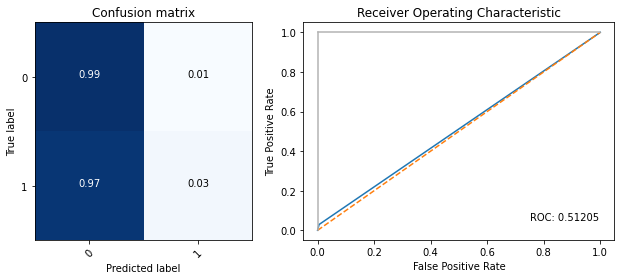

0.5120477218000438

In [0]:
plot_cmroc(y_test,lgbm_gs_ub.predict(X_test))

# Dimensionality Reduction and Features Analysis

Dimensionality reduction with:
    
    1.Principal Component Analysis(PCA)
    2.t-SNE
    3.UMAP
As well as a few methods to feature selection:
   
    1.Stepwise Feature selection
    2.Recursive Feature elimination
    3.Feature Importance Analysis
Performed on a Logistic Regressor and Random Forest Classifier

In [0]:
import warnings
from sklearn.feature_selection import RFE,SelectKBest,chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import scipy.stats as ss
import joblib
from mlxtend.feature_selection import SequentialFeatureSelector



/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
fi_data=data.drop(columns=['ORIGIN']).copy()
X,y=fi_data.drop(columns='CARAVAN'),fi_data.CARAVAN

# Exploratory Data Analysis


# Dimensionality Reduction

In [0]:
#plotting function
def scatter_density(data,labels,sca_title='',den_title="",**kwargs):
    """plot a scatter plot and a density plot Args:
             data:2-d array ,shape (n_samples,2)
             labels:array-like,class labels to be used for coloring scatterplot
              sca_title:str,scatter plot title
              den_title:str,density plot title
              **kwargs:keyword arguments passed to seaborn.
              Kdeplot
              Returns:
                     ax,matplotlib axis object"""
    fig,ax=plt.subplots(1,2,figsize=(10,4),sharey=True,sharex=True)
    #,gridspec_kw={'width_ratios':[50,50,4]}
    dataneg=data[labels==0]
    datapos=data[labels==1]
    sns.scatterplot(data[:,0],data[:,1],hue=labels,ax=ax[0])
    #sns.scatterplot(dataneg[:,0],dataneg[:,1],palette='Blues',ax=ax[0],alpha=0.06)
    #sns.scatterplot(datapos[:,0],datapos[:,1],palette='Oranges',ax=ax[0],alpha=1)
    sns.kdeplot(datapos[:,0],datapos[:,1],ax=ax[1],cmap='Oranges',**kwargs)
    sns.kdeplot(dataneg[:,0],dataneg[:,1],ax=ax[1],map='Blues',nlevels=30,**kwargs,shade=True,shade_lowest=False)#,cbar=True,cbar_ax=ax[2])
    ax[0].set_title(sca_title)
    ax[1].set_title(den_title)
    fig.tight_layout()
    plt.show()
    return ax

# PCA(principal Component analysis)

PCA is effected by differences in magnitude well begin by scaling the data.

In [0]:
from sklearn.decomposition import PCA
Xs=pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)
pca=PCA(random_state=RS)
Xpca=pca.fit_transform(Xs)

implement PCA without proper Scaling

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'map', 'nlevels'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


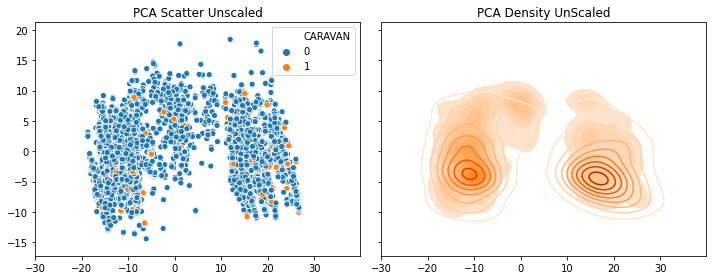

In [0]:

pca=PCA(random_state=RS)
_Xpca_raw=PCA(n_components=2,random_state=RS).fit_transform(X)
scatter_density(_Xpca_raw,y,'PCA Scatter Unscaled','PCA Density UnScaled');


The density plot shows a clear separation between two groups and even the scatter plot shows some degree of misleading grouping.Properly scaled ,things will look quite a bit different.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'map', 'nlevels'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


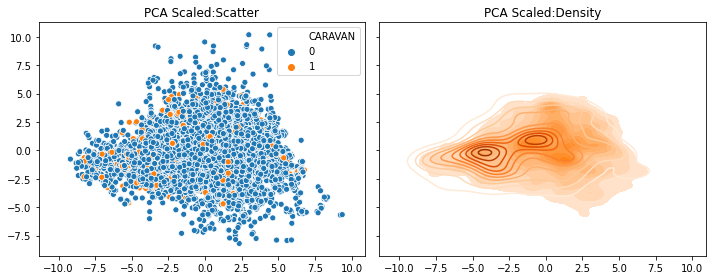

In [0]:
from sklearn.decomposition import PCA
Xs=pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)
pca=PCA(random_state=RS)
Xpca=pca.fit_transform(Xs)

Xpca=pca.fit_transform(Xs)
scatter_density(Xpca,y,'PCA Scaled:Scatter','PCA Scaled:Density');

Now we are dealing with the accurate representation of the data,an amorphous point mass.That is why it is so important to check that the assumptions are model are met,otherwise it is all too easy to head down a path leading to dead ends or inavalid conclusions.

In [0]:
pca.explained_variance_ratio_[:3]

array([0.11035515, 0.05773411, 0.04685836])

About 16% of variance can be explained by these first two abstract components.

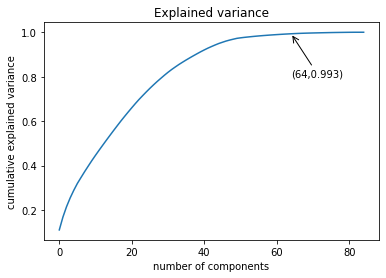

In [0]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.annotate('(64,0.993)',xy=(64,0.993),xytext=(64,0.8),fontsize='medium',arrowprops={'arrowstyle':'->','mutation_scale':15})
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Explained variance')
plt.show()

# t-SNE(T-distributed Stochastic Neighbor Embedding)


In [0]:
!pip install openTSNE

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 44.1MB/s 
  Created wheel for pynndescent: filename=pynndescent-0.4.7-cp36-none-any.whl size=42021 sha256=d470f9083ac11fc0800b7cf25d9929a5ad76767923d0f7bf1222aaa6ea080175
  Stored in directory: /root/.cache/pip/wheels/c6/a4/50/338b69c613a5002af6855a53f3f178530533682e4cd397cd49
Successfully built pynndescent


In [0]:
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger
tsne=TSNE(perplexity=75,learning_rate=500,n_iter=1000,metric='euclidean',negative_gradient_method='bh',n_jobs=4,callbacks=ErrorLogger(),random_state=RS)
Xembd=tsne.fit(Xs)

Iteration   50, KL divergence  4.4822, 50 iterations in 6.5042 sec
Iteration  100, KL divergence  4.4716, 50 iterations in 6.5853 sec
Iteration  150, KL divergence  4.4716, 50 iterations in 6.6653 sec
Iteration  200, KL divergence  4.4715, 50 iterations in 6.6403 sec
Iteration  250, KL divergence  4.4715, 50 iterations in 6.5862 sec
Iteration   50, KL divergence  2.3886, 50 iterations in 6.3946 sec
Iteration  100, KL divergence  2.0118, 50 iterations in 6.3869 sec
Iteration  150, KL divergence  1.8194, 50 iterations in 6.4753 sec
Iteration  200, KL divergence  1.7014, 50 iterations in 6.4653 sec
Iteration  250, KL divergence  1.6209, 50 iterations in 6.4819 sec
Iteration  300, KL divergence  1.5637, 50 iterations in 6.4986 sec
Iteration  350, KL divergence  1.5220, 50 iterations in 6.5311 sec
Iteration  400, KL divergence  1.4906, 50 iterations in 6.4678 sec
Iteration  450, KL divergence  1.4673, 50 iterations in 6.5727 sec
Iteration  500, KL divergence  1.4502, 50 iterations in 6.6743

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'map', 'nlevels'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


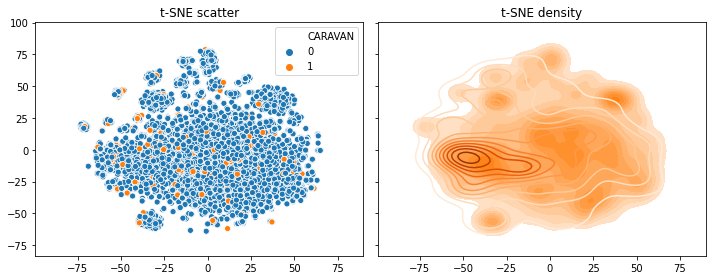

In [0]:
scatter_density(Xembd,y,'t-SNE scatter','t-SNE density');

Although we do begin to see some small clusters taking shape.Depending on parameter choice,t-SNE has been shown to spuriously cluster.Highest density areas overlap between positive and negative saples and there are only a few small pockets where they have successfully separated.

In [0]:
!pip install 'umap-learn==0.3.10'

**UMAP(Uniform manifold Approximation and Projection)**

UMAP is relatively recent development in non-linear dimensionality reduction.

In [0]:
import umap.umap_ as umap

ump=umap.UMAP(n_neighbors=30,min_dist=0.2,random_state=RS,verbose=True)
Xumap=ump.fit_transform(Xs,y)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.2, n_components=2, n_epochs=None,
     n_neighbors=30, negative_sample_rate=5, random_state=410,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Sun Apr  5 05:49:48 2020 Finding Nearest Neighbors
Sun Apr  5 05:49:48 2020 Building RP forest with 10 trees


/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))


Sun Apr  5 05:49:49 2020 NN descent for 13 iterations


/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/nndes

	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
Sun Apr  5 05:49:58 2020 Finished Nearest Neighbor Search
Sun Apr  5 05:50:01 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Apr  5 05:50:50 2020 Finished embedding


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'map', 'nlevels'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


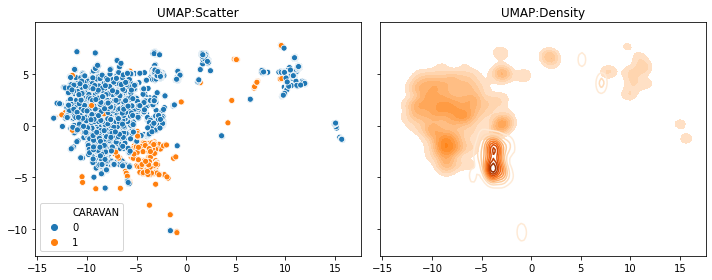

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7c6af29b0>,
      dtype=object)

In [0]:
scatter_density(Xumap,y,'UMAP:Scatter','UMAP:Density')

In [0]:
ump=umap.UMAP(n_neighbors=30,min_dist=0.2,random_state=RS,verbose=False)
Xumap=ump.fit_transform(Xs)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'map', 'nlevels'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


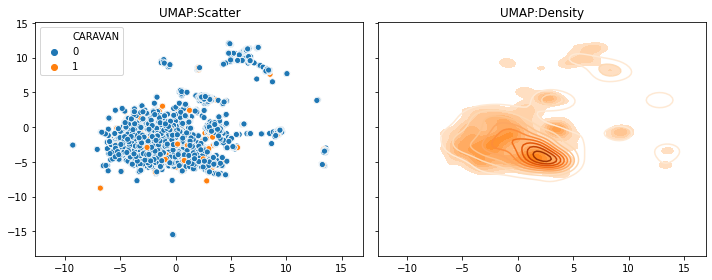

In [0]:
ump=umap.UMAP(n_neighbors=30,min_dist=0.2,random_state=RS,verbose=False)
Xumap=ump.fit_transform(Xs)
scatter_density(Xumap,y,'UMAP:Scatter','UMAP:Density');